# Style transfer using CNN

### Import dependencies

In [1]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras import backend
from keras.models import Model

import time

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


### Loading Images : Content Image and Style Image

In [2]:
def load_image(image_path):
    image = Image.open(image_path)
    return image

We will also need to resize the image to reduce computational overhead

In [3]:
def resize_image(image, h, w):
    resized_image = image.resize((h, w))
    return resized_image

We need to specifiy a default dimension for our images, we're setting it to 512 X 512

In [4]:
h = 512
w = 512

Now we need to load the images and resize them. First the style image and then the content image.

In [5]:
style_img_path = "images/style/van_gogh_portrait.jpg"

style_img = load_image(style_img_path)
style_img_resized = resize_image(style_img, h, w)

Let's check the style image.

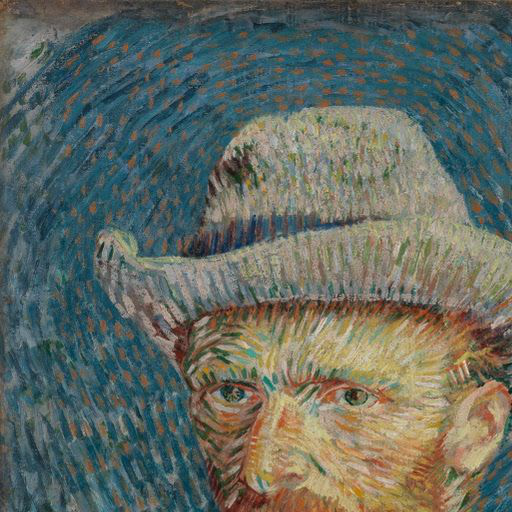

In [6]:
style_img_resized

Now the content image.

In [7]:
content_img_path = "images/content/shakib.jpg"
content_img = load_image(content_img_path)
content_img_resized = resize_image(content_img, h, w)

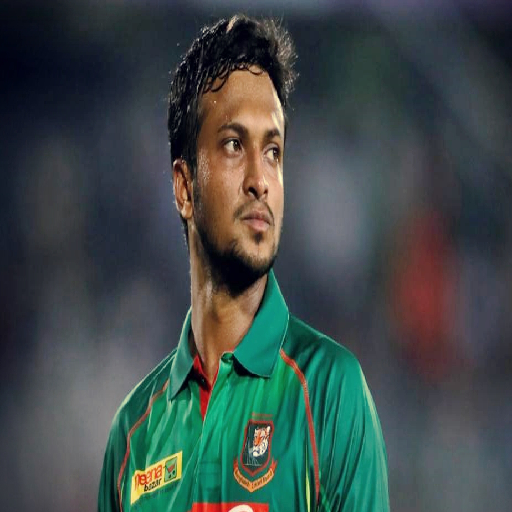

In [8]:
content_img_resized

### Converting images to arrays for numerical analysis

In [9]:
style_img_array = np.asarray(style_img_resized, dtype="float32")
content_img_array = np.asarray(content_img_resized, dtype="float32")

We need to add an additional dimension to the arrays for bias.

In [10]:
style_img_array = np.expand_dims(style_img_array, axis=0)
content_img_array = np.expand_dims(content_img_array, axis=0)

In [11]:
print(content_img_array.shape)
print(style_img_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Now we need the average RGB value of an image.

In [12]:
def get_avg_rgb(image_array):
    avg_rgb = np.mean(image_array, axis=(0, 1, 2))
    return avg_rgb

In [13]:
style_avg_rgb = get_avg_rgb(style_img_array)
content_avg_rgb = get_avg_rgb(content_img_array)

print(style_avg_rgb)
print(content_avg_rgb)

[  98.45629883  105.61911011   97.47766113]
[ 62.18221283  74.72062683  73.3687439 ]


Now we need to subtract the avg rgb from image and format it in BGR format (as stated in VGG16 paper)

In [14]:
style_array = style_img_array - style_avg_rgb
content_array = content_img_array - content_avg_rgb

In [15]:
def convert_to_bgr(image_array):
    return image_array[:, :, :, ::-1]

In [16]:
conv_style = convert_to_bgr(style_array)
conv_content = convert_to_bgr(content_array)

### Feeding images as variable into Keras

In [17]:
style_var = backend.variable(conv_style)
content_var = backend.variable(conv_content)

In [18]:
combination_img = backend.placeholder((1, h, w, 3))

Since using Tensorflow backend and it needs tensors, we convert the image data into one concatened tensor.

In [19]:
input_tensor = backend.concatenate([content_var, style_var, combination_img], axis = 0)

### Getting the model ready

In [20]:
model = VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)

Let's load the layers

In [21]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [22]:
# arbitrary values

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [23]:
loss = backend.variable(0.)

### Measuring content loss

In [24]:
def get_content_loss(content, combo):
    return backend.sum(backend.square(content - combo))

In [25]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * get_content_loss(content_image_features, combination_features)

### Measuring style loss

The best way to get style loss is to measure the gram matrix. The terms of gram matrix are proportional to specific features in the style image. So makes it easy for extraction. 

In [26]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [27]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = h * w
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

We need to define which layers in convonet we should be using.

In [28]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [29]:
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Total variation loss

In [30]:
def total_variation_loss(x):
    a = backend.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    b = backend.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [31]:
loss += total_variation_weight * total_variation_loss(combination_img)

### Gradient for Optimisation

In [32]:
grad = backend.gradients(loss, combination_img)

### Evaluation

In [33]:
outputs = [loss]
outputs += grad
f_outputs = backend.function([combination_img], outputs)

In [34]:
def eval_loss_and_grads(x):
    x = x.reshape((1, h, w, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [35]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [36]:
evaluator = Evaluator()

### Optimisation

In [37]:
x = np.random.uniform(0, 255, (1, h, w, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.90175e+10
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 7.97707e+09
Iteration 1 completed in 7s
Start of iteration 2
Current loss value: 6.55111e+09
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 5.96842e+09
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 5.69343e+09
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 5.56134e+09
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 5.47842e+09
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 5.42927e+09
Iteration 7 completed in 7s
Start of iteration 8
Current loss value: 5.39866e+09
Iteration 8 completed in 7s
Start of iteration 9
Current loss value: 5.37856e+09
Iteration 9 completed in 7s


In [38]:
x = x.reshape((h, w, 3))

Now we need to go back to RGB from BGR. Same procedure. Also we need to get average rgb value.

In [39]:
x = x[:, :, ::-1]

In [40]:
avg_rgb_x = get_avg_rgb(x)

In [41]:
x = x + avg_rgb_x

In [42]:
x = np.clip(x, 0, 255).astype("uint8")

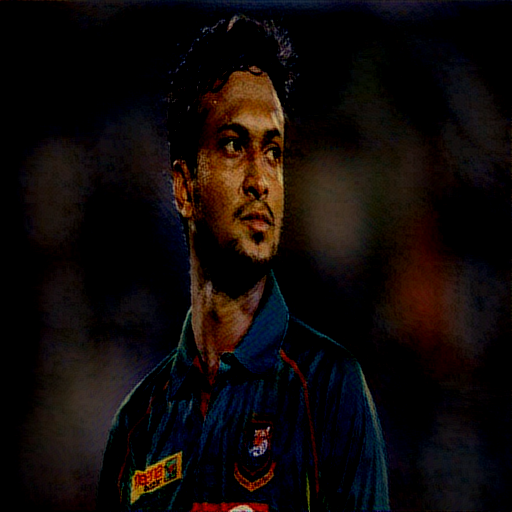

In [43]:
Image.fromarray(x)